# Ali NN

## Exploratory Data Analysis

## Training Neural Networks

### Imports and Cuda Device

In [11]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
import plotly.express as px
from torch.utils.tensorboard import SummaryWriter


%matplotlib inline     
sns.set(color_codes=True)

import gc

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")

#### KAN Class

In [13]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

### Data Import

In [14]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [15]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [16]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [17]:
dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))

datasets_labeled_smartS_mcf = {}
for name, dataset in datasets.items():
    tmpDataset = dataset.copy()
    tmpDataset["mcf"] = np.ones_like(dataset.iloc[:, 0]) if "MCF7" in name else np.zeros_like(dataset.iloc[:, 0])
    tmpDataset["smart"] = np.ones_like(dataset.iloc[:, 0]) if "SmartSeq" in name else np.zeros_like(dataset.iloc[:, 0])
    datasets_labeled_smartS_mcf[name] = tmpDataset

In [18]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

#### Train-Test Split

In [19]:
datasets_train = {}
datasets_test = {}

for name, dataset in datasets.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_train[name] = train_dataset.astype(np.int32)
    datasets_test[name] = test_dataset.astype(np.int32)

datasets_labeled_smartS_mcf_train = {}
datasets_labeled_smartS_mcf_test = {}

for name, dataset in datasets_labeled_smartS_mcf.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_labeled_smartS_mcf_train[name] = train_dataset.astype(np.int32)
    datasets_labeled_smartS_mcf_test[name] = test_dataset.astype(np.int32)

merged_train_dataset = pd.concat(datasets_train.values()).fillna(0).astype(np.int32)
merged_test_dataset = pd.concat(datasets_test.values()).fillna(0).astype(np.int32)

merged_labeled_smartS_mcf_train_dataset = pd.concat(datasets_labeled_smartS_mcf_train.values()).fillna(0).astype(np.int32)
merged_labeled_smartS_mcf_test_dataset = pd.concat(datasets_labeled_smartS_mcf_test.values()).fillna(0).astype(np.int32)

#### Define Dataset

In [ ]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(1 if self.idx[index] in self.data_norm else 0,  dtype=torch.float32, device=device)
        return x, y

#### Initialize Datasets

### Define Neural Networks

In [21]:
class NNBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNBig, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [22]:
class NNMedium(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNMedium, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [23]:
class KANBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANBig, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [24]:
class KANSmall(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANSmall, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [25]:
class KANTiny(nn.Module):
    def __init__(self, in_size, H1):
        super(KANTiny, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

### Helpers

#### Model Measuring

In [26]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)

In [27]:
@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [28]:
data_loaders_train = {}
data_loaders_test = {}

for name in datasets_train.keys():
    data_loaders_train[name] = DataLoader(NNDataset(datasets_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_test[name] = DataLoader(NNDataset(datasets_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_train = DataLoader(NNDataset(merged_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_test = DataLoader(NNDataset(merged_test_dataset, merged_norm_idx), batch_size=64)

data_loaders_labeled_smartS_mcf_train = {}
data_loaders_labeled_smartS_mcf_test = {}

for name in datasets_train.keys():
    data_loaders_labeled_smartS_mcf_train[name] = DataLoader(NNDataset(datasets_labeled_smartS_mcf_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_labeled_smartS_mcf_test[name] = DataLoader(NNDataset(datasets_labeled_smartS_mcf_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_labeled_smartS_mcf_train = DataLoader(NNDataset(merged_labeled_smartS_mcf_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_labeled_smartS_mcf_test = DataLoader(NNDataset(merged_labeled_smartS_mcf_test_dataset, merged_norm_idx), batch_size=64)

#### Training Helpers

In [29]:
def train(model, train_config, writer=None):
    total_epochs = 0
    for config_type, config in train_config:
        if config_type == 0:
            iter_count, subtrain_config = config
            for _ in range(iter_count):
                total_epochs += train(model, subtrain_config, writer)
        elif config_type == 1:
            num_epochs, data_loader, test_loader, optimizer, criterion = config
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs[:, 0], labels)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                    optimizer.step()
                    running_loss += loss.item()

                writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
                measure_model_log(writer, model, test_loader, total_epochs)
                writer.flush()
                total_epochs += 1
        else:
            raise Exception("Invalid training config")
    return total_epochs
        

In [30]:
#lr_sgd = 1e-2
#lr_ada = 1e-2
#lr_admw = 1e-3
#wd_admw = 1e-4

# Define the optimizer
#sgd = optim.SGD(model.parameters(), lr=lr_sgd)
#adm = optim.Adam(model.parameters(), lr=lr_adm)
#ada = optim.Adagrad(model.parameters(), lr=lr_ada)
#admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

### Training Neural Networks

#### Training Over Individual Datasets

In [31]:
input_size = 3000

##### Traditional Neural Networks

In [ ]:
models = {}
for name in data_loaders_test.keys():
    model = NNMedium(input_size, 4096, 1024, 512).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

In [ ]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [ ]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

##### KAN (Kolmogorov Arnold Networks)

In [32]:
models = {}
for name in data_loaders_test.keys():
    model = KANTiny(input_size, 64).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 133.2124786376953
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  2%|▏         | 1/50 [00:00<00:33,  1.46it/s]

Epoch 2, Loss: 6.825803354382515
F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%


  4%|▍         | 2/50 [00:00<00:21,  2.28it/s]

Epoch 3, Loss: 7.255246892571449


  6%|▌         | 3/50 [00:01<00:16,  2.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.0


  8%|▊         | 4/50 [00:01<00:14,  3.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:01<00:12,  3.49it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.47736334800720215


 12%|█▏        | 6/50 [00:01<00:12,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:02<00:11,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.0


 16%|█▌        | 8/50 [00:02<00:11,  3.78it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0


 18%|█▊        | 9/50 [00:02<00:10,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.0


 20%|██        | 10/50 [00:02<00:10,  3.93it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 11, Loss: 5.133291340264616e-28
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 22%|██▏       | 11/50 [00:03<00:11,  3.40it/s]

Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:10,  3.64it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:03<00:09,  3.81it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.2489517778158188


 28%|██▊       | 14/50 [00:04<00:09,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 9.49437141418457


 30%|███       | 15/50 [00:04<00:08,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:07,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:07,  4.08it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 19, Loss: 0.4927588999271393


 38%|███▊      | 19/50 [00:05<00:07,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:05<00:07,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:06,  4.23it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:05<00:06,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0


 46%|████▌     | 23/50 [00:06<00:06,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:06,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:06<00:05,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:06<00:05,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 54%|█████▍    | 27/50 [00:07<00:06,  3.37it/s]

Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:06,  3.60it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:07<00:05,  3.65it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:05,  3.80it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:08<00:04,  4.01it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 34, Loss: 0.0424070879817009


 68%|██████▊   | 34/50 [00:08<00:03,  4.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:09<00:03,  4.18it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:09<00:02,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 2.034475564956665


 78%|███████▊  | 39/50 [00:10<00:02,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:10<00:02,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:10<00:02,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:10<00:01,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  4.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:11<00:01,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  4.21it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:11<00:00,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0


 94%|█████████▍| 47/50 [00:12<00:00,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:12<00:00,  4.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 98%|█████████▊| 49/50 [00:12<00:00,  3.26it/s]

Epoch 50, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 773.0351765950521


  2%|▏         | 1/50 [00:00<00:13,  3.73it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 54.054054054054056%
Epoch 2, Loss: 397.13902791341144


  4%|▍         | 2/50 [00:00<00:11,  4.12it/s]

F1 Score: 0.7555555555555555
Recall: 1.0
Accuracy on test: 70.27027027027027%
Epoch 3, Loss: 174.55777994791666


  6%|▌         | 3/50 [00:00<00:11,  4.25it/s]

F1 Score: 0.8387096774193549
Recall: 0.7647058823529411
Accuracy on test: 86.48648648648648%
Epoch 4, Loss: 21.20755608876546


  8%|▊         | 4/50 [00:00<00:10,  4.33it/s]

F1 Score: 0.9032258064516129
Recall: 0.8235294117647058
Accuracy on test: 91.8918918918919%
Epoch 5, Loss: 31.64124631881714


 10%|█         | 5/50 [00:01<00:10,  4.34it/s]

F1 Score: 0.8292682926829268
Recall: 1.0
Accuracy on test: 81.08108108108108%
Epoch 6, Loss: 15.96223751703898


 12%|█▏        | 6/50 [00:01<00:10,  4.39it/s]

F1 Score: 0.8666666666666667
Recall: 0.7647058823529411
Accuracy on test: 89.1891891891892%
Epoch 7, Loss: 1.1524152345955372


 14%|█▍        | 7/50 [00:01<00:09,  4.38it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 8, Loss: 5.846139550209045


 16%|█▌        | 8/50 [00:01<00:09,  4.33it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 9, Loss: 2.207048942645391


 18%|█▊        | 9/50 [00:02<00:09,  4.38it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 10, Loss: 0.38903455932935077


 20%|██        | 10/50 [00:02<00:09,  4.35it/s]

F1 Score: 0.9090909090909091
Recall: 0.8823529411764706
Accuracy on test: 91.8918918918919%
Epoch 11, Loss: 3.3109321296215057


 22%|██▏       | 11/50 [00:02<00:09,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.27018853028615314


 24%|██▍       | 12/50 [00:02<00:08,  4.25it/s]

F1 Score: 0.8125
Recall: 0.7647058823529411
Accuracy on test: 83.78378378378379%
Epoch 13, Loss: 3.8832060943047204


 26%|██▌       | 13/50 [00:03<00:08,  4.29it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 14, Loss: 0.1456584334373474


 28%|██▊       | 14/50 [00:03<00:08,  4.38it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 15, Loss: 0.20798651377360025


 30%|███       | 15/50 [00:03<00:08,  4.37it/s]

F1 Score: 0.7142857142857143
Recall: 0.5882352941176471
Accuracy on test: 78.37837837837837%
Epoch 16, Loss: 2.815504719813665


 32%|███▏      | 16/50 [00:03<00:07,  4.40it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 17, Loss: 0.24404455224672952


 34%|███▍      | 17/50 [00:03<00:07,  4.41it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 18, Loss: 0.16553865373134613


 36%|███▌      | 18/50 [00:04<00:07,  4.45it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 19, Loss: 0.32665349543094635


 38%|███▊      | 19/50 [00:04<00:06,  4.45it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.16819933553536734


 40%|████      | 20/50 [00:04<00:06,  4.47it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.2601218471924464


 42%|████▏     | 21/50 [00:04<00:06,  4.45it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.15537661810715994


 44%|████▍     | 22/50 [00:05<00:06,  4.30it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 23, Loss: 0.18373181174198785


 46%|████▌     | 23/50 [00:05<00:06,  4.36it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 24, Loss: 0.12328000615040462
F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%


 48%|████▊     | 24/50 [00:05<00:08,  3.23it/s]

Epoch 25, Loss: 0.1406727929910024


 50%|█████     | 25/50 [00:06<00:07,  3.51it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 26, Loss: 0.32661337219178677


 52%|█████▏    | 26/50 [00:06<00:06,  3.75it/s]

F1 Score: 0.8947368421052632
Recall: 1.0
Accuracy on test: 89.1891891891892%
Epoch 27, Loss: 0.15269720057646433


 54%|█████▍    | 27/50 [00:06<00:05,  3.97it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 28, Loss: 0.15221941967805228


 56%|█████▌    | 28/50 [00:06<00:05,  4.11it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 29, Loss: 0.1477100575963656


 58%|█████▊    | 29/50 [00:06<00:05,  4.14it/s]

F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 30, Loss: 0.11516040315230687


 60%|██████    | 30/50 [00:07<00:04,  4.16it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 31, Loss: 0.24868729213873544


 62%|██████▏   | 31/50 [00:07<00:04,  4.22it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 32, Loss: 0.14590618014335632
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 64%|██████▍   | 32/50 [00:07<00:04,  4.09it/s]

Epoch 33, Loss: 0.10313827047745387


 66%|██████▌   | 33/50 [00:07<00:04,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.1298671414454778


 68%|██████▊   | 34/50 [00:08<00:03,  4.19it/s]

F1 Score: 0.7333333333333333
Recall: 0.6470588235294118
Accuracy on test: 78.37837837837837%
Epoch 35, Loss: 0.6145521203676859


 70%|███████   | 35/50 [00:08<00:03,  4.23it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 36, Loss: 0.08040859798590343
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 72%|███████▏  | 36/50 [00:08<00:03,  4.15it/s]

Epoch 37, Loss: 0.10848275323708852
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 74%|███████▍  | 37/50 [00:08<00:03,  4.10it/s]

Epoch 38, Loss: 0.06711588116983573


 76%|███████▌  | 38/50 [00:09<00:02,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 39, Loss: 0.10084181030591328


 78%|███████▊  | 39/50 [00:09<00:02,  4.22it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 40, Loss: 0.09724872807661693


 80%|████████  | 40/50 [00:09<00:02,  4.27it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 41, Loss: 0.07584023972352345


 82%|████████▏ | 41/50 [00:09<00:02,  4.28it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 42, Loss: 0.09392853329579036
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 84%|████████▍ | 42/50 [00:10<00:01,  4.04it/s]

Epoch 43, Loss: 0.07498551284273465


 86%|████████▌ | 43/50 [00:10<00:01,  4.12it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 44, Loss: 0.10314223666985829


 88%|████████▊ | 44/50 [00:10<00:01,  4.20it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 45, Loss: 0.11442452669143677


 90%|█████████ | 45/50 [00:10<00:01,  4.27it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 46, Loss: 0.09705450137456258


 92%|█████████▏| 46/50 [00:10<00:00,  4.30it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 47, Loss: 0.07561613991856575


 94%|█████████▍| 47/50 [00:11<00:00,  4.26it/s]

F1 Score: 0.9090909090909091
Recall: 0.8823529411764706
Accuracy on test: 91.8918918918919%
Epoch 48, Loss: 0.04553971625864506
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 96%|█████████▌| 48/50 [00:11<00:00,  4.14it/s]

Epoch 49, Loss: 0.11197315156459808


 98%|█████████▊| 49/50 [00:11<00:00,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 50, Loss: 0.09427482883135478


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]

F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.10952471519349576


 33%|███▎      | 1/3 [00:07<00:14,  7.30s/it]

F1 Score: 0.9823943661971831
Recall: 0.9831636648394675
Accuracy on test: 97.91955617198336%
Epoch 2, Loss: 0.06209442095755431


 67%|██████▋   | 2/3 [00:13<00:06,  6.83s/it]

F1 Score: 0.98359375
Recall: 0.9859044635865309
Accuracy on test: 98.05825242718447%
Epoch 3, Loss: 0.05378787876776939


100%|██████████| 3/3 [00:20<00:00,  6.76s/it]

F1 Score: 0.9853487009181481
Recall: 0.9874706342991386
Accuracy on test: 98.26629680998613%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.19780760481143775


 33%|███▎      | 1/3 [00:05<00:10,  5.49s/it]

F1 Score: 0.9315789473684211
Recall: 0.9131556319862425
Accuracy on test: 94.68845760980592%
Epoch 2, Loss: 0.09927563231600367


 67%|██████▋   | 2/3 [00:09<00:04,  4.73s/it]

F1 Score: 0.9460154241645244
Recall: 0.9492691315563199
Accuracy on test: 95.70990806945862%
Epoch 3, Loss: 0.08053902979008853
F1 Score: 0.9474576271186441
Recall: 0.9613069647463457
Accuracy on test: 95.77800476676882%


100%|██████████| 3/3 [00:14<00:00,  4.76s/it]


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


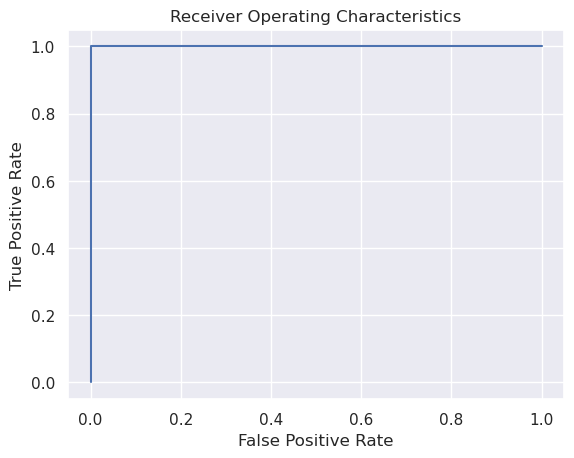

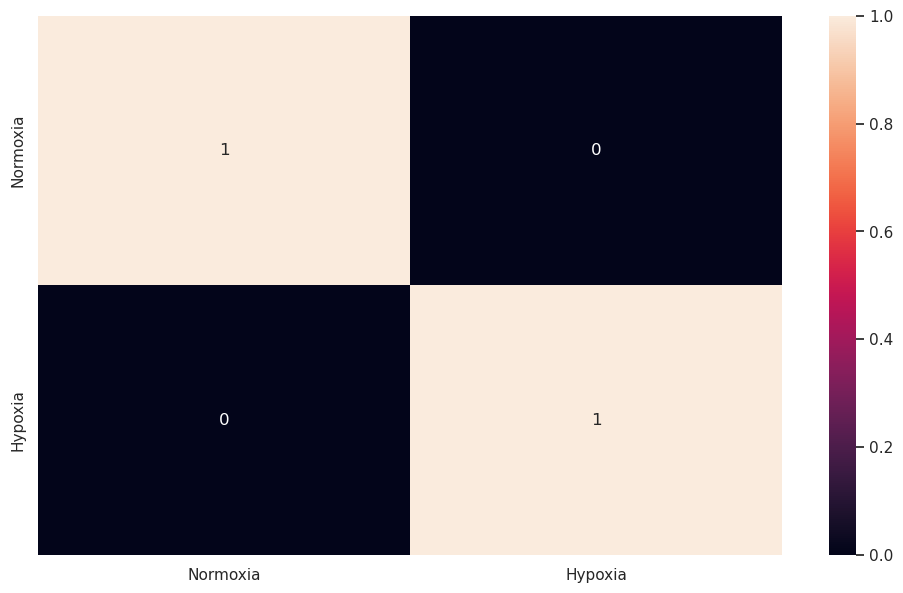

HCC1806_SmartSeq
F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%


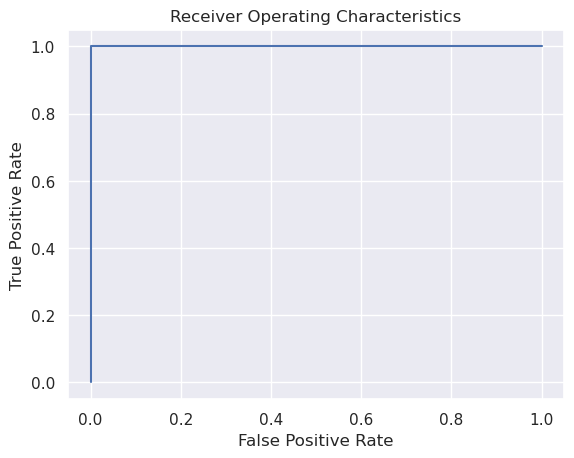

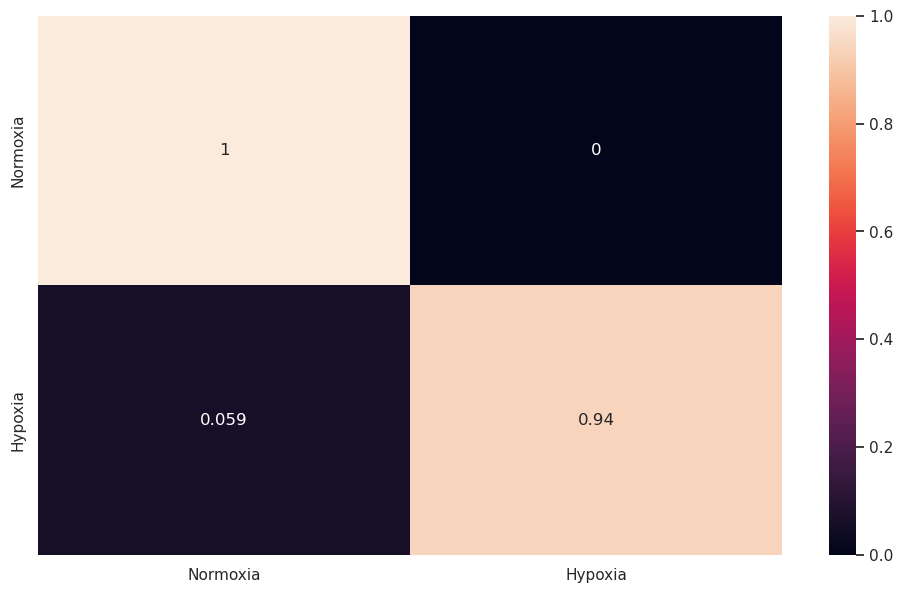

MCF7_DropSeq
F1 Score: 0.9851504493942946
Recall: 0.9870790916209867
Accuracy on test: 98.24318076745261%


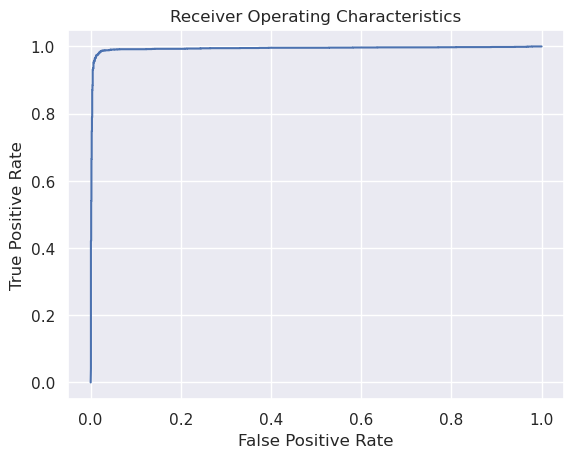

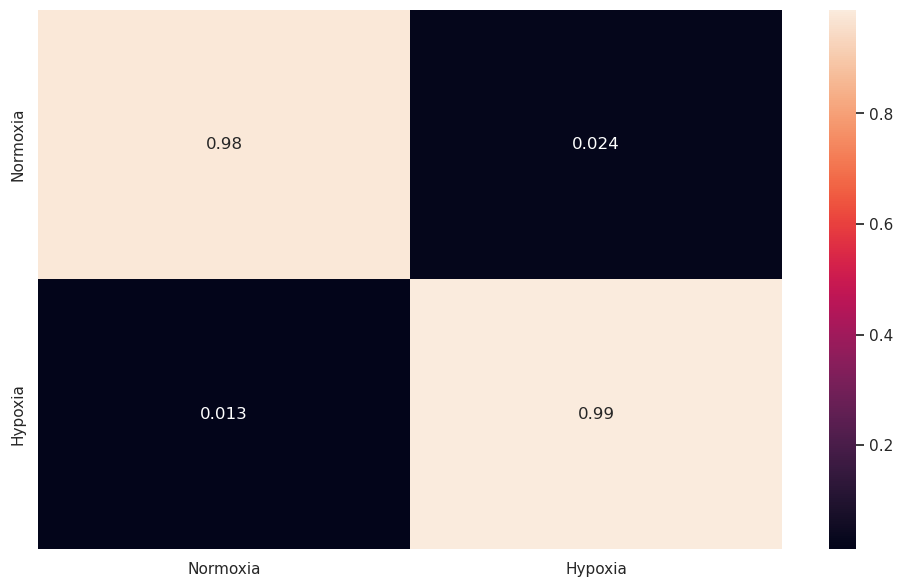

HCC1806_DropSeq
F1 Score: 0.942120828052387
Recall: 0.9587274290627688
Accuracy on test: 95.33537623425264%


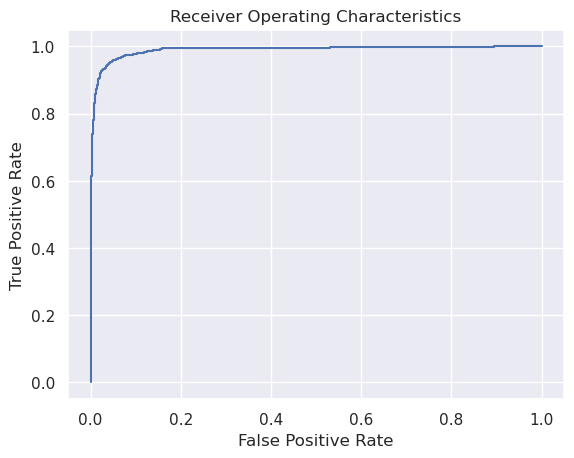

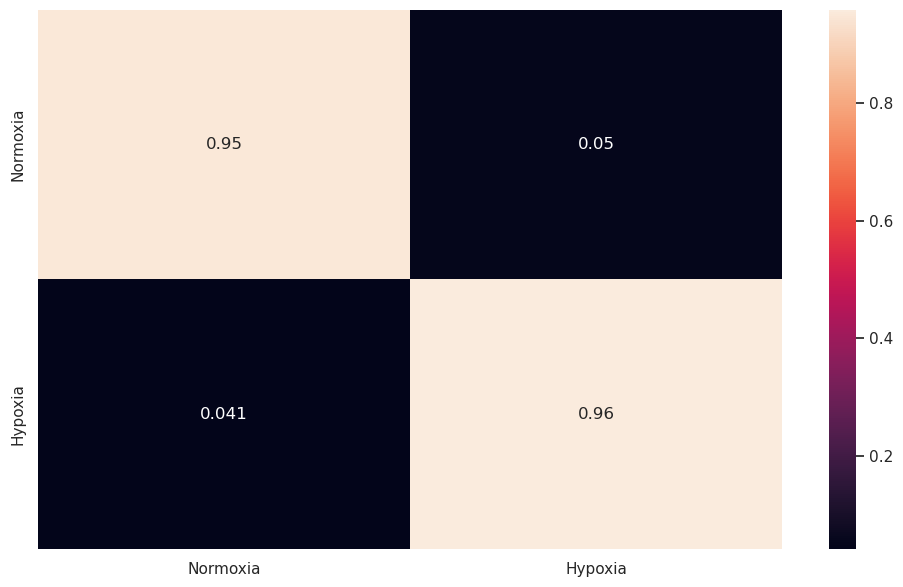

In [33]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [34]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

#### Training Over Merged Datasets

In [38]:
input_size = merged_labeled_smartS_mcf_train_dataset.shape[1]

##### Traditional Neural Network

In [39]:
model = NNBig(input_size, 4096, 2048, 1024).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [40]:
train_config = [
    [1, [10, merged_data_loader_labeled_smartS_mcf_train, merged_data_loader_labeled_smartS_mcf_test, ada, bcelogits]]
]

In [41]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 2097.71841102087


 10%|█         | 1/10 [00:18<02:44, 18.23s/it]

F1 Score: 0.9654803318169655
Recall: 0.959829741952647
Accuracy on test: 96.48979591836735%
Epoch 2, Loss: 0.11302491271584902


 20%|██        | 2/10 [00:36<02:25, 18.25s/it]

F1 Score: 0.9658743858717301
Recall: 0.9675445597233306
Accuracy on test: 96.50340136054422%
Epoch 3, Loss: 0.49561694710858356


 30%|███       | 3/10 [00:54<02:07, 18.15s/it]

F1 Score: 0.9693349263241736
Recall: 0.9712689545091779
Accuracy on test: 96.85714285714285%
Epoch 4, Loss: 0.04392177121974426


 40%|████      | 4/10 [01:12<01:49, 18.19s/it]

F1 Score: 0.9664268585131894
Recall: 0.9648842777334398
Accuracy on test: 96.57142857142857%
Epoch 5, Loss: 0.638812300781335


 50%|█████     | 5/10 [01:31<01:31, 18.26s/it]

F1 Score: 0.96513470681458
Recall: 0.9720670391061452
Accuracy on test: 96.40816326530613%
Epoch 6, Loss: 0.022606546616191776


 60%|██████    | 6/10 [01:49<01:13, 18.32s/it]

F1 Score: 0.966094934184284
Recall: 0.9664804469273743
Accuracy on test: 96.53061224489797%
Epoch 7, Loss: 0.1164736158216001


 70%|███████   | 7/10 [02:08<00:55, 18.38s/it]

F1 Score: 0.9670825590655694
Recall: 0.9691407289172652
Accuracy on test: 96.62585034013605%
Epoch 8, Loss: 0.16651503307147922


 80%|████████  | 8/10 [02:26<00:36, 18.42s/it]

F1 Score: 0.9660790598290598
Recall: 0.9622239957435488
Accuracy on test: 96.54421768707483%
Epoch 9, Loss: 0.26326096631421697


 90%|█████████ | 9/10 [02:45<00:18, 18.46s/it]

F1 Score: 0.9675167785234899
Recall: 0.9587656291566906
Accuracy on test: 96.70748299319727%
Epoch 10, Loss: 0.09256869295187962
F1 Score: 0.9652231845436375
Recall: 0.9635541367384943
Accuracy on test: 96.44897959183673%


100%|██████████| 10/10 [03:03<00:00, 18.40s/it]


10

F1 Score: 0.9655908242197919
Recall: 0.9630220803405161
Accuracy on test: 96.48979591836735%


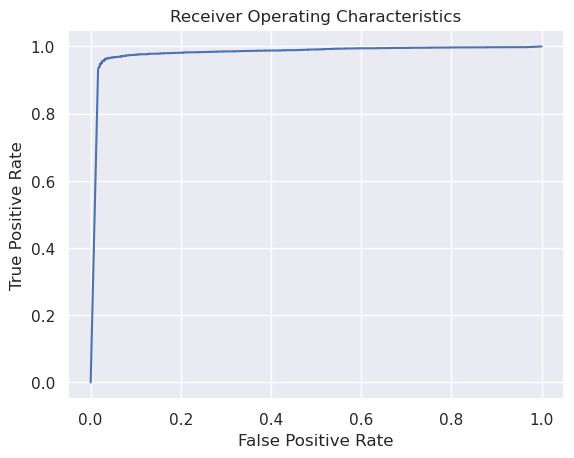

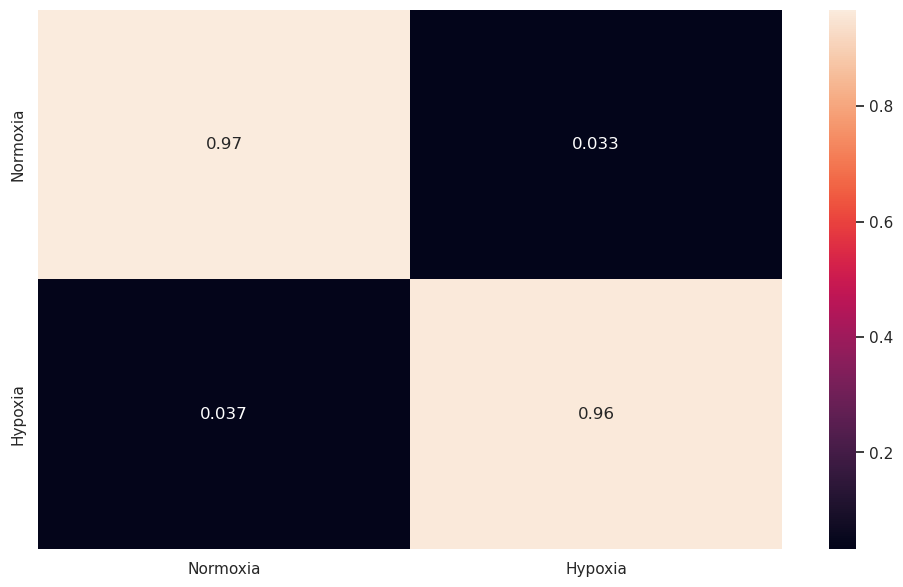

In [43]:
measure_model(model, merged_data_loader_labeled_smartS_mcf_test)

In [44]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

##### KAN (Kolmogorov Arnold Networks)

In [46]:
model = KANTiny(input_size, 512).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [47]:
train_config = [
    [1, [10, merged_data_loader_labeled_smartS_mcf_train, merged_data_loader_labeled_smartS_mcf_test, ada, bcelogits]]
]

In [48]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 3.185873494264872


 10%|█         | 1/10 [00:21<03:13, 21.56s/it]

F1 Score: 0.9623018516051685
Recall: 0.9608938547486033
Accuracy on test: 96.14965986394559%
Epoch 2, Loss: 0.9667729081990926


 20%|██        | 2/10 [00:43<02:53, 21.65s/it]

F1 Score: 0.9687416510820198
Recall: 0.9646182495344506
Accuracy on test: 96.81632653061224%
Epoch 3, Loss: 0.8792724277216779


 30%|███       | 3/10 [01:05<02:32, 21.73s/it]

F1 Score: 0.9700026546323334
Recall: 0.9720670391061452
Accuracy on test: 96.92517006802721%
Epoch 4, Loss: 0.1473688607306584


 40%|████      | 4/10 [01:27<02:11, 21.83s/it]

F1 Score: 0.9720893141945773
Recall: 0.9728651237031125
Accuracy on test: 97.14285714285714%
Epoch 5, Loss: 0.04064513306416895


 50%|█████     | 5/10 [01:49<01:49, 21.88s/it]

F1 Score: 0.970043935561177
Recall: 0.9691407289172652
Accuracy on test: 96.93877551020408%
Epoch 6, Loss: 0.17559861716935815


 60%|██████    | 6/10 [02:11<01:27, 21.92s/it]

F1 Score: 0.9708067940552016
Recall: 0.9731311519021016
Accuracy on test: 97.00680272108843%
Epoch 7, Loss: 0.07679038298437776


 70%|███████   | 7/10 [02:32<01:05, 21.89s/it]

F1 Score: 0.9696727853152434
Recall: 0.9696727853152434
Accuracy on test: 96.89795918367346%
Epoch 8, Loss: 0.05017623059988103


 80%|████████  | 8/10 [02:54<00:43, 21.89s/it]

F1 Score: 0.9715501196490295
Recall: 0.9720670391061452
Accuracy on test: 97.08843537414967%
Epoch 9, Loss: 0.01897750301387809


 90%|█████████ | 9/10 [03:16<00:21, 21.98s/it]

F1 Score: 0.9688912523265089
Recall: 0.9694067571162543
Accuracy on test: 96.81632653061224%
Epoch 10, Loss: 0.21158833774768382


100%|██████████| 10/10 [03:38<00:00, 21.90s/it]

F1 Score: 0.9690694278507899
Recall: 0.9710029263101889
Accuracy on test: 96.82993197278911%


10

F1 Score: 0.9700026546323334
Recall: 0.9720670391061452
Accuracy on test: 96.92517006802721%


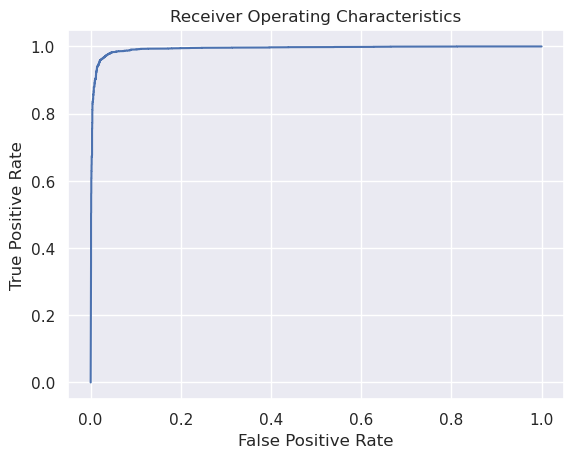

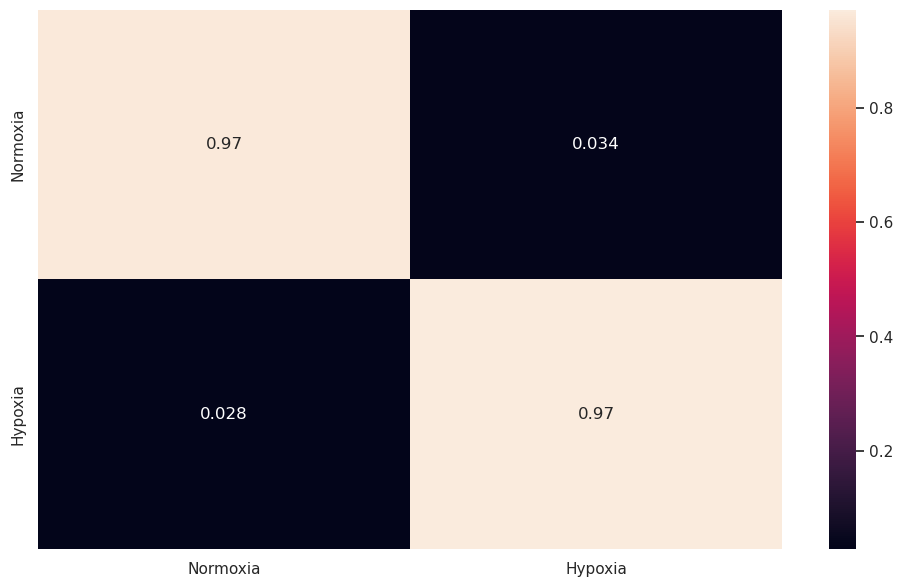

In [49]:
measure_model(model, merged_data_loader_labeled_smartS_mcf_test)

In [50]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Autoencoders

#### Define Models

In [51]:
class AutoEnc(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(AutoEnc, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.LeakyReLU())
            encoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.LeakyReLU())
            decoder_layers.append(nn.Dropout(0.5))
            prev_dim = h_dim
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.final_layer = nn.Linear(hidden_dims[0], input_dim)
        
    def encode(self, x):
        return self.fc_mu(self.encoder(x))
    
    def decode(self, z):
        return self.final_layer(self.decoder(z))
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h

In [52]:
class MAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(MAE, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim

        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.relu = nn.LeakyReLU()
        
    def encode(self, x):
        return self.relu(self.encoder(x))
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h, self.decoder.weight

#### Define Parameters

In [53]:
input_size = merged_train_dataset.shape[1]
latent_size = 3

#### Traditional Autoencoders

##### Initialize Model

In [54]:
model = AutoEnc(input_size, [1000, 200], latent_size).to(device)

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

##### Loss Functions

In [55]:
mseloss = nn.MSELoss()

##### Train

In [56]:
train_config = [
    [5000, merged_data_loader_train, ada]
]

In [60]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            MSE.backward()
            
            running_losses += MSE.item()

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1, Loss: 1368.7264588670562


  0%|          | 1/5000 [00:10<14:07:43, 10.17s/it]

Epoch 2, Loss: 1348.0165771552079


  0%|          | 2/5000 [00:20<14:09:45, 10.20s/it]

Epoch 3, Loss: 1293.8766095431279


  0%|          | 3/5000 [00:30<14:09:53, 10.20s/it]

Epoch 4, Loss: 1337.4392357223708


  0%|          | 4/5000 [00:40<14:05:59, 10.16s/it]

Epoch 5, Loss: 1300.1233285252815


  0%|          | 5/5000 [00:50<14:06:37, 10.17s/it]

Epoch 6, Loss: 1357.2955875137577


  0%|          | 6/5000 [01:01<14:07:51, 10.19s/it]

Epoch 7, Loss: 1247.8278382320443


  0%|          | 7/5000 [01:11<14:07:22, 10.18s/it]

Epoch 8, Loss: 1255.3493105017944


  0%|          | 8/5000 [01:21<14:07:35, 10.19s/it]

Epoch 9, Loss: 1250.578113699575


  0%|          | 9/5000 [01:31<14:08:11, 10.20s/it]

Epoch 10, Loss: 1252.0015845208065


  0%|          | 10/5000 [01:41<14:07:46, 10.19s/it]

Epoch 11, Loss: 1214.8118850004737


  0%|          | 11/5000 [01:51<14:03:17, 10.14s/it]

Epoch 12, Loss: 1222.943156302623


  0%|          | 12/5000 [02:01<13:56:40, 10.06s/it]

Epoch 13, Loss: 1268.902531412762


  0%|          | 13/5000 [02:11<13:50:23,  9.99s/it]

Epoch 14, Loss: 1205.7384173568823


  0%|          | 14/5000 [02:21<13:47:02,  9.95s/it]

Epoch 15, Loss: 1243.974022490272


  0%|          | 15/5000 [02:31<13:43:07,  9.91s/it]

Epoch 16, Loss: 1207.4856529887604


  0%|          | 16/5000 [02:41<13:41:02,  9.88s/it]

Epoch 17, Loss: 1297.5062545564188


  0%|          | 17/5000 [02:50<13:37:48,  9.85s/it]

Epoch 18, Loss: 1204.4802670139982


  0%|          | 18/5000 [03:00<13:37:31,  9.85s/it]

Epoch 19, Loss: 1234.6869547662852


  0%|          | 19/5000 [03:10<13:36:49,  9.84s/it]

Epoch 20, Loss: 1199.8454642719873


  0%|          | 20/5000 [03:20<13:35:59,  9.83s/it]

Epoch 21, Loss: 1203.1846057406585


  0%|          | 21/5000 [03:30<13:36:16,  9.84s/it]

Epoch 22, Loss: 1163.6066495866555


  0%|          | 22/5000 [03:39<13:34:22,  9.82s/it]

Epoch 23, Loss: 1214.810355804569


  0%|          | 23/5000 [03:49<13:34:50,  9.82s/it]

Epoch 24, Loss: 1202.2852585665235


  0%|          | 24/5000 [03:59<13:33:42,  9.81s/it]

Epoch 25, Loss: 1218.1985620214887


  0%|          | 25/5000 [04:09<13:33:31,  9.81s/it]

Epoch 26, Loss: 1200.9202449321747


  1%|          | 26/5000 [04:19<13:33:02,  9.81s/it]

Epoch 27, Loss: 1189.2050630181704


  1%|          | 27/5000 [04:29<13:32:53,  9.81s/it]

Epoch 28, Loss: 1181.5118291690621


  1%|          | 28/5000 [04:38<13:33:04,  9.81s/it]

Epoch 29, Loss: 1165.04001088719


  1%|          | 29/5000 [04:48<13:30:53,  9.79s/it]

Epoch 30, Loss: 1157.8802640313363


  1%|          | 30/5000 [04:58<13:31:39,  9.80s/it]

Epoch 31, Loss: 1174.6510185335965


  1%|          | 31/5000 [05:08<13:30:51,  9.79s/it]

Epoch 32, Loss: 1160.2514068900891


  1%|          | 32/5000 [05:17<13:31:44,  9.80s/it]

Epoch 33, Loss: 1152.995903603927


  1%|          | 33/5000 [05:27<13:30:41,  9.79s/it]

Epoch 34, Loss: 1154.2732562281515


  1%|          | 34/5000 [05:37<13:30:30,  9.79s/it]

Epoch 35, Loss: 1161.2199201472426


  1%|          | 35/5000 [05:47<13:28:22,  9.77s/it]

Epoch 36, Loss: 1134.7479313722447


  1%|          | 36/5000 [05:57<13:29:55,  9.79s/it]

Epoch 37, Loss: 1115.6571872967093


  1%|          | 37/5000 [06:06<13:30:04,  9.79s/it]

Epoch 38, Loss: 1138.9811025171823


  1%|          | 38/5000 [06:16<13:30:34,  9.80s/it]

Epoch 39, Loss: 1125.3394919636132


  1%|          | 39/5000 [06:26<13:29:44,  9.79s/it]

Epoch 40, Loss: 1156.2895105315615


  1%|          | 40/5000 [06:36<13:29:03,  9.79s/it]

Epoch 41, Loss: 1140.731275008619


  1%|          | 41/5000 [06:46<13:28:38,  9.78s/it]

Epoch 42, Loss: 1132.4572651982955


  1%|          | 42/5000 [07:00<13:47:23, 10.01s/it]


KeyboardInterrupt: 

In [61]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [62]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [63]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

#### Guided Autoencoder

##### Initialize Model

In [64]:
model = AutoEnc(input_size, [2048, 1024], latent_size).to(device)

lr_ada = 1e-2
adm = optim.Adagrad(model.parameters(), lr=lr_ada)

##### Loss Functions

In [65]:
mseloss = nn.MSELoss()

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

##### Train

In [66]:
train_config = [
    [100, merged_data_loader_train, adm]
]

In [67]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        running_losses = np.array([0.0,0.0, 0.0])
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, mu = model(inputs)
            MSE = mseloss(recon_batch, inputs)

            latentMSE = bceloss(mu[:, 2], labels)

            MSE.backward(retain_graph=True)
            latentMSE.backward()
            

            running_losses[0] += MSE.item()
            running_losses[1] += latentMSE.item()

            nn.utils.clip_grad_norm_(model.parameters(), 1)

            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 5359057.186567077: [5.35905586e+06 1.32511395e+00 0.00000000e+00]


  1%|          | 1/100 [00:13<21:34, 13.07s/it]

Epoch 2, Loss: 2304.136637808698: [2.30330277e+03 8.33869253e-01 0.00000000e+00]


  2%|▏         | 2/100 [00:26<21:21, 13.08s/it]

Epoch 3, Loss: 1768.7212377709295: [1.76781645e+03 9.04783438e-01 0.00000000e+00]


  3%|▎         | 3/100 [00:39<21:11, 13.11s/it]

Epoch 4, Loss: 1581.0742724781937: [1.58010250e+03 9.71770851e-01 0.00000000e+00]


  4%|▍         | 4/100 [00:52<21:01, 13.14s/it]

Epoch 5, Loss: 1457.8088677968951: [1.45686360e+03 9.45263901e-01 0.00000000e+00]


  5%|▌         | 5/100 [01:05<20:50, 13.16s/it]

Epoch 6, Loss: 1398.0803968572502: [1.39712893e+03 9.51471295e-01 0.00000000e+00]


  6%|▌         | 6/100 [01:19<20:42, 13.22s/it]

Epoch 7, Loss: 1427.3332213108226: [1.42640386e+03 9.29362656e-01 0.00000000e+00]


  7%|▋         | 7/100 [01:32<20:31, 13.24s/it]

Epoch 8, Loss: 1337.1930813035078: [1.33622764e+03 9.65443735e-01 0.00000000e+00]


  8%|▊         | 8/100 [01:45<20:20, 13.27s/it]

Epoch 9, Loss: 1317.7589598160034: [1.31684610e+03 9.12859425e-01 0.00000000e+00]


  9%|▉         | 9/100 [01:59<20:10, 13.31s/it]

Epoch 10, Loss: 1235.2875967668126: [1.23439126e+03 8.96340235e-01 0.00000000e+00]


 10%|█         | 10/100 [02:12<19:58, 13.32s/it]

Epoch 11, Loss: 1274.7244940989428: [1.27382146e+03 9.03032769e-01 0.00000000e+00]


 11%|█         | 11/100 [02:25<19:48, 13.36s/it]

Epoch 12, Loss: 1201.2329371289188: [1.20033007e+03 9.02869167e-01 0.00000000e+00]


 12%|█▏        | 12/100 [02:39<19:37, 13.39s/it]

Epoch 13, Loss: 1167.961250937635: [1.16707597e+03 8.85278873e-01 0.00000000e+00]


 13%|█▎        | 13/100 [02:52<19:26, 13.41s/it]

Epoch 14, Loss: 1126.7139266506506: [1.12579228e+03 9.21650755e-01 0.00000000e+00]


 14%|█▍        | 14/100 [03:06<19:13, 13.42s/it]

Epoch 15, Loss: 1124.9771237994767: [1.12409456e+03 8.82563082e-01 0.00000000e+00]


 15%|█▌        | 15/100 [03:19<19:02, 13.44s/it]

Epoch 16, Loss: 1156.0318429060553: [1.15511635e+03 9.15491371e-01 0.00000000e+00]


 16%|█▌        | 16/100 [03:33<18:52, 13.48s/it]

Epoch 17, Loss: 1108.4223505668585: [1.10755735e+03 8.65003013e-01 0.00000000e+00]


 17%|█▋        | 17/100 [03:46<18:42, 13.52s/it]

Epoch 18, Loss: 1121.3258562309181: [1.12041338e+03 9.12479248e-01 0.00000000e+00]


 18%|█▊        | 18/100 [04:00<18:30, 13.54s/it]

Epoch 19, Loss: 1073.969575417564: [1.07310557e+03 8.64006438e-01 0.00000000e+00]


 19%|█▉        | 19/100 [04:14<18:17, 13.55s/it]

Epoch 20, Loss: 1087.5426380958145: [1.08670313e+03 8.39504577e-01 0.00000000e+00]


 20%|██        | 20/100 [04:27<18:05, 13.57s/it]

Epoch 21, Loss: 1041.3639229583675: [1.04049659e+03 8.67331134e-01 0.00000000e+00]


 21%|██        | 21/100 [04:41<17:51, 13.57s/it]

Epoch 22, Loss: 1067.7911456791685: [1.06694171e+03 8.49439118e-01 0.00000000e+00]


 22%|██▏       | 22/100 [04:54<17:39, 13.58s/it]

Epoch 23, Loss: 1076.2464648935022: [1.07540786e+03 8.38600085e-01 0.00000000e+00]


 23%|██▎       | 23/100 [05:08<17:24, 13.57s/it]

Epoch 24, Loss: 1046.8099216805042: [1.04595336e+03 8.56563478e-01 0.00000000e+00]


 24%|██▍       | 24/100 [05:21<17:09, 13.54s/it]

Epoch 25, Loss: 1014.1400910042449: [1.01327602e+03 8.64067645e-01 0.00000000e+00]


 25%|██▌       | 25/100 [05:35<16:53, 13.51s/it]

Epoch 26, Loss: 1024.2149211370336: [1.02338172e+03 8.33200192e-01 0.00000000e+00]


 26%|██▌       | 26/100 [05:48<16:37, 13.48s/it]

Epoch 27, Loss: 997.2520755318733: [9.96424692e+02 8.27383171e-01 0.00000000e+00]


 27%|██▋       | 27/100 [06:02<16:22, 13.46s/it]

Epoch 28, Loss: 979.8780135280817: [9.79022714e+02 8.55299115e-01 0.00000000e+00]


 28%|██▊       | 28/100 [06:15<16:08, 13.45s/it]

Epoch 29, Loss: 1046.0438842280105: [1.04520401e+03 8.39876863e-01 0.00000000e+00]


 29%|██▉       | 29/100 [06:28<15:54, 13.44s/it]

Epoch 30, Loss: 992.9968742870811: [9.92174055e+02 8.22819530e-01 0.00000000e+00]


 30%|███       | 30/100 [06:42<15:39, 13.43s/it]

Epoch 31, Loss: 946.1820313779126: [9.45344359e+02 8.37672582e-01 0.00000000e+00]


 31%|███       | 31/100 [06:55<15:26, 13.42s/it]

Epoch 32, Loss: 952.1645573830723: [9.51317808e+02 8.46748894e-01 0.00000000e+00]


 32%|███▏      | 32/100 [07:09<15:11, 13.41s/it]

Epoch 33, Loss: 954.9289530766819: [9.54064797e+02 8.64155658e-01 0.00000000e+00]


 33%|███▎      | 33/100 [07:22<14:58, 13.41s/it]

Epoch 34, Loss: 930.7450975394291: [9.29910407e+02 8.34690575e-01 0.00000000e+00]


 34%|███▍      | 34/100 [07:35<14:44, 13.41s/it]

Epoch 35, Loss: 942.6075702225833: [9.41758641e+02 8.48928728e-01 0.00000000e+00]


 35%|███▌      | 35/100 [07:49<14:31, 13.41s/it]

Epoch 36, Loss: 908.1557448028561: [9.07330727e+02 8.25017543e-01 0.00000000e+00]


 36%|███▌      | 36/100 [08:02<14:18, 13.42s/it]

Epoch 37, Loss: 912.3140221185477: [9.11499122e+02 8.14900078e-01 0.00000000e+00]


 37%|███▋      | 37/100 [08:16<14:04, 13.40s/it]

Epoch 38, Loss: 937.8601616151315: [9.37010974e+02 8.49187870e-01 0.00000000e+00]


 38%|███▊      | 38/100 [08:29<13:49, 13.38s/it]

Epoch 39, Loss: 984.1604664314438: [9.83304907e+02 8.55559581e-01 0.00000000e+00]


 39%|███▉      | 39/100 [08:42<13:35, 13.37s/it]

Epoch 40, Loss: 942.5539012023149: [9.41725301e+02 8.28600379e-01 0.00000000e+00]


 40%|████      | 40/100 [08:56<13:22, 13.38s/it]

Epoch 41, Loss: 889.3058272904078: [8.88506004e+02 7.99823108e-01 0.00000000e+00]


 41%|████      | 41/100 [09:09<13:09, 13.37s/it]

Epoch 42, Loss: 867.5150954072085: [8.66703418e+02 8.11677482e-01 0.00000000e+00]


 42%|████▏     | 42/100 [09:22<12:55, 13.37s/it]

Epoch 43, Loss: 879.4431547819536: [8.78603374e+02 8.39780863e-01 0.00000000e+00]


 43%|████▎     | 43/100 [09:36<12:42, 13.37s/it]

Epoch 44, Loss: 880.0116883019577: [8.79198861e+02 8.12827617e-01 0.00000000e+00]


 44%|████▍     | 44/100 [09:49<12:28, 13.37s/it]

Epoch 45, Loss: 887.5500041040691: [8.86741815e+02 8.08188783e-01 0.00000000e+00]


 45%|████▌     | 45/100 [10:03<12:17, 13.41s/it]

Epoch 46, Loss: 838.81618543783: [837.9723903    0.84379514   0.        ]


 46%|████▌     | 46/100 [10:16<12:08, 13.49s/it]

Epoch 47, Loss: 854.2658901787609: [8.53416982e+02 8.48907828e-01 0.00000000e+00]


 47%|████▋     | 47/100 [10:30<11:55, 13.50s/it]

Epoch 48, Loss: 871.4831049187003: [8.70647462e+02 8.35642726e-01 0.00000000e+00]


 48%|████▊     | 48/100 [10:43<11:41, 13.49s/it]

Epoch 49, Loss: 811.869849544655: [811.04034431   0.82950523   0.        ]


 49%|████▉     | 49/100 [10:57<11:27, 13.47s/it]

Epoch 50, Loss: 797.7738273509752: [796.9453402    0.82848715   0.        ]


 50%|█████     | 50/100 [11:10<11:11, 13.44s/it]

Epoch 51, Loss: 831.1264888787878: [830.25081401   0.87567487   0.        ]


 51%|█████     | 51/100 [11:23<10:55, 13.38s/it]

Epoch 52, Loss: 839.1725126309555: [8.38335296e+02 8.37216652e-01 0.00000000e+00]


 52%|█████▏    | 52/100 [11:37<10:39, 13.33s/it]

Epoch 53, Loss: 801.3225579154316: [800.50385522   0.81870269   0.        ]


 53%|█████▎    | 53/100 [11:50<10:26, 13.32s/it]

Epoch 54, Loss: 821.4601891643745: [820.62764054   0.83254863   0.        ]


 54%|█████▍    | 54/100 [12:03<10:12, 13.31s/it]

Epoch 55, Loss: 822.0391205613952: [821.20738053   0.83174003   0.        ]


 55%|█████▌    | 55/100 [12:16<09:57, 13.29s/it]

Epoch 56, Loss: 823.8791243863674: [823.02920266   0.84992172   0.        ]


 56%|█████▌    | 56/100 [12:30<09:44, 13.28s/it]

Epoch 57, Loss: 797.6651655409452: [796.82036523   0.84480031   0.        ]


 57%|█████▋    | 57/100 [12:43<09:30, 13.26s/it]

Epoch 58, Loss: 835.7764135443749: [834.93815734   0.83825621   0.        ]


 58%|█████▊    | 58/100 [12:56<09:16, 13.25s/it]

Epoch 59, Loss: 809.8582980955412: [809.01545031   0.84284778   0.        ]


 59%|█████▉    | 59/100 [13:09<09:02, 13.24s/it]

Epoch 60, Loss: 824.1641565500433: [823.30357042   0.86058613   0.        ]


 60%|██████    | 60/100 [13:23<08:48, 13.22s/it]

Epoch 61, Loss: 823.0226866816947: [822.17979172   0.84289496   0.        ]


 61%|██████    | 61/100 [13:36<08:35, 13.21s/it]

Epoch 62, Loss: 810.0279992094843: [809.18946493   0.83853428   0.        ]


 62%|██████▏   | 62/100 [13:49<08:21, 13.19s/it]

Epoch 63, Loss: 828.9128941406914: [828.07678061   0.83611353   0.        ]


 63%|██████▎   | 63/100 [14:02<08:06, 13.16s/it]

Epoch 64, Loss: 799.9694164397656: [799.12363329   0.84578315   0.        ]


 64%|██████▍   | 64/100 [14:15<07:52, 13.14s/it]

Epoch 65, Loss: 746.9936615962149: [746.18341366   0.81024793   0.        ]


 65%|██████▌   | 65/100 [14:28<07:39, 13.12s/it]

Epoch 66, Loss: 788.6897471436121: [787.87903639   0.81071075   0.        ]


 66%|██████▌   | 66/100 [14:41<07:26, 13.13s/it]

Epoch 67, Loss: 802.9550073798308: [802.13238295   0.82262443   0.        ]


 67%|██████▋   | 67/100 [14:54<07:12, 13.11s/it]

Epoch 68, Loss: 773.1589055187651: [772.30110803   0.85779749   0.        ]


 68%|██████▊   | 68/100 [15:07<06:59, 13.09s/it]

Epoch 69, Loss: 784.826523543432: [783.9645261    0.86199744   0.        ]


 69%|██████▉   | 69/100 [15:20<06:46, 13.10s/it]

Epoch 70, Loss: 774.0758790893842: [773.24760119   0.8282779    0.        ]


 70%|███████   | 70/100 [15:34<06:33, 13.10s/it]

Epoch 71, Loss: 748.2170108606965: [747.3883168    0.82869406   0.        ]


 71%|███████   | 71/100 [15:47<06:19, 13.08s/it]

Epoch 72, Loss: 750.9532637788706: [750.11795387   0.8353099    0.        ]


 72%|███████▏  | 72/100 [16:00<06:05, 13.07s/it]

Epoch 73, Loss: 766.8996707519576: [766.06670342   0.83296733   0.        ]


 73%|███████▎  | 73/100 [16:13<05:53, 13.08s/it]

Epoch 74, Loss: 737.7260765549594: [736.91206797   0.81400859   0.        ]


 74%|███████▍  | 74/100 [16:26<05:39, 13.06s/it]

Epoch 75, Loss: 793.8338302900108: [792.99550924   0.83832105   0.        ]


 75%|███████▌  | 75/100 [16:39<05:26, 13.07s/it]

Epoch 76, Loss: 784.1807082619986: [783.34523191   0.83547636   0.        ]


 76%|███████▌  | 76/100 [16:52<05:14, 13.08s/it]

Epoch 77, Loss: 831.1713017241588: [830.33476729   0.83653444   0.        ]


 77%|███████▋  | 77/100 [17:05<05:00, 13.09s/it]

Epoch 78, Loss: 748.5206450391288: [747.69109412   0.82955092   0.        ]


 78%|███████▊  | 78/100 [17:18<04:47, 13.09s/it]

Epoch 79, Loss: 766.7016484973259: [765.85750948   0.84413902   0.        ]


 79%|███████▉  | 79/100 [17:31<04:34, 13.08s/it]

Epoch 80, Loss: 768.1068127509529: [767.28426928   0.82254347   0.        ]


 80%|████████  | 80/100 [17:44<04:21, 13.08s/it]

Epoch 81, Loss: 749.4547710277733: [748.60845382   0.84631721   0.        ]


 81%|████████  | 81/100 [17:57<04:08, 13.06s/it]

Epoch 82, Loss: 738.1628539870196: [737.33816077   0.82469322   0.        ]


 82%|████████▏ | 82/100 [18:10<03:55, 13.06s/it]

Epoch 83, Loss: 738.2445202150808: [737.41578127   0.82873894   0.        ]


 83%|████████▎ | 83/100 [18:23<03:42, 13.07s/it]

Epoch 84, Loss: 746.3442949321377: [745.52397083   0.8203241    0.        ]


 84%|████████▍ | 84/100 [18:37<03:29, 13.06s/it]

Epoch 85, Loss: 749.4368917863742: [748.59334937   0.84354242   0.        ]


 85%|████████▌ | 85/100 [18:50<03:15, 13.04s/it]

Epoch 86, Loss: 758.4715166047214: [757.63959016   0.83192644   0.        ]


 86%|████████▌ | 86/100 [19:03<03:02, 13.07s/it]

Epoch 87, Loss: 719.4931738403717: [718.65681757   0.83635627   0.        ]


 87%|████████▋ | 87/100 [19:16<02:49, 13.07s/it]

Epoch 88, Loss: 763.5917827443851: [762.75792603   0.83385672   0.        ]


 88%|████████▊ | 88/100 [19:41<02:41, 13.42s/it]


KeyboardInterrupt: 

In [68]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        recon_batch, mu = model(inputs)
        outputs.extend(nn.Sigmoid()(mu).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [69]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [70]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

#### Modal Autoencoder

##### Define Losses

In [71]:
total_epochs = 0

mseloss = nn.MSELoss()

I = torch.eye(input_size).to(device)

def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

def mae_loss(W2, lambda_m):
    
    # Orthogonality constraint loss
    W2_T = W2.t()
    
    # Construct the matrix M
    diag_elements = torch.pow(W2.norm(dim=0), -2)
    M = torch.diag(diag_elements)

    orthogonality_term = W2 @ M @ W2_T
    orthogonality_term -= I
    orthogonality_loss = torch.norm(orthogonality_term, p='fro') ** 2
    
    # Combined loss
    total_loss = lambda_m * orthogonality_loss
    return total_loss

##### Initialize Model

In [72]:
model = MAE(input_size, latent_size).to(device)

lr_adm = 1e-3
adm = optim.Adam(model.parameters(), lr=lr_adm)

##### Train

In [73]:
train_config = [
    [10, merged_data_loader_train, adm]
]

In [74]:
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        subepochs = tqdm(data_loaderr, position=epoch)
        running_losses = np.array([0.0,0.0,0.0])
        for inputs, labels in subepochs:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, m, W2 = model(inputs)

            # Calculate the loss
            loss  = F.mse_loss(recon_batch, inputs)
            loss1 = mae_loss(W2, 0.01)
            loss2 = bceloss(m[:, 2], labels)
            
            loss.backward(retain_graph=True)
            loss1.backward(retain_graph=True)
            loss2.backward()

            running_losses[0] = loss.item()
            running_losses[1] = loss1.item()
            running_losses[2] = loss2.item()

            subepochs.set_description(f"Current loss: {running_losses/(subepochs.n + 1)}")
            #print(f"Loss: {MSE.item()}, {KLD.item()}, {TC.item()}", flush=True)
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loaderr)}: {running_losses/len(data_loaderr)}", flush=True)
        total_epochs += 1
        subepochs.reset()
        subepochs.n = 0

Current loss: [0.00050085 0.37575548 0.00249872]: 100%|██████████| 230/230 [00:13<00:00, 17.07it/s]            

Epoch 1, Loss: 0.3787550529384095: [0.00050085 0.37575548 0.00249872]



Current loss: [7.53420741e+00 3.77398928e-01 2.39292373e-03]: 100%|██████████| 230/230 [00:13<00:00, 16.68it/s]

Epoch 2, Loss: 7.879590566002804: [7.50144998e+00 3.75758063e-01 2.38251971e-03]



 20%|██        | 2/10 [00:27<01:49, 13.66s/it]

























































































































































































































































































































































Current loss: [8.46052896e+01 3.77398029e-01 2.37023414e-03]: 100%|██████████| 230/230 [00:13<00:00, 16.53it/s]

Epoch 3, Loss: 84.61555765348932: [8.42374406e+01 3.75757168e-01 2.35992877e-03]



 30%|███       | 3/10 [00:41<01:36, 13.78s/it]



































































Current loss: [25.90139335  4.11544727  0.0464559 ]:  10%|▉         | 22/230 [00:01<00:12, 16.09it/s]
 30%|███       | 3/10 [00:42<01:39, 14.19s/it]


KeyboardInterrupt: 

In [75]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in merged_data_loader_test:
        outputs.extend(nn.Sigmoid()(model.encoder(inputs)).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [76]:
fig = px.scatter_3d(pred_df, x=0, y=1, z=2, color="Condition", opacity=0.3)
fig.show()

In [77]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

## Merging Best Classifiers

In [79]:
import pickle as pkl
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

In [80]:
models = {}
for name, df in datasets.items():
    models[name] = {}
    for model in ['xgboost_mkII', 'rf', "svm", "sgd"]:
        model_name = f'{model}_{name}'
        with open(f'models/{model_name}.pkl', 'rb') as f:
            models[name][model] = pkl.load(f)

In [81]:
class KANTinyWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
            outputs = self.model(X_tensor)
            predicted = nn.Sigmoid()(outputs[:, 0])
            return (predicted.round().cpu().numpy()).astype(int)

    def predict_proba(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32, device=self.device)
            outputs = self.model(X_tensor)
            probabilities = nn.Sigmoid()(outputs[:, 0])
            return np.vstack((1 - probabilities.cpu().numpy(), probabilities.cpu().numpy())).T
        
    def fit(self, X, y):
        pass

In [82]:
def model_test_performance(name, best_model, X_test, y_test, probability=True):
    print(f'Evaluating the performance on the test set for {name}:\n')
    y_pred = best_model.predict(X_test)
    if probability:
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'ROC AUC: {roc_auc}')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # display confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    classes = ('Normoxia', 'Hypoxia')
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.title(f'Confusion matrix for {name}')
    plt.show()

In [84]:
input_size = 3000
for name in data_loaders_test.keys():
    model = KANTiny(input_size, 64).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name]["kan_raw"] = model
for name, df in datasets.items():
    models[name]["kan"] = KANTinyWrapper(models[name]["kan_raw"], device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 141.5666046142578
F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%


  2%|▏         | 1/50 [00:00<00:13,  3.53it/s]

Epoch 2, Loss: 1.83284598166794e-07


  4%|▍         | 2/50 [00:00<00:12,  3.88it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 3, Loss: 8.841796904802322


  6%|▌         | 3/50 [00:00<00:11,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.04543443024158478
F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%


  8%|▊         | 4/50 [00:01<00:11,  3.90it/s]

Epoch 5, Loss: 5.478580057621002
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 10%|█         | 5/50 [00:01<00:11,  3.77it/s]

Epoch 6, Loss: 1.389150857925415


 12%|█▏        | 6/50 [00:01<00:11,  3.87it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 7, Loss: 1.5376761555671692


 14%|█▍        | 7/50 [00:01<00:10,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 4.120613932609558


 16%|█▌        | 8/50 [00:02<00:10,  3.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0


 18%|█▊        | 9/50 [00:02<00:10,  4.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.0


 20%|██        | 10/50 [00:02<00:09,  4.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 11, Loss: 0.0


 22%|██▏       | 11/50 [00:02<00:09,  4.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.5162853598594666


 24%|██▍       | 12/50 [00:03<00:09,  4.02it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 13, Loss: 0.9648038746972158


 26%|██▌       | 13/50 [00:03<00:09,  4.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 28%|██▊       | 14/50 [00:03<00:11,  3.09it/s]

Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:04<00:10,  3.34it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:09,  3.57it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:08,  3.70it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:08,  3.80it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:04<00:08,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 1.748916658200723e-33


 40%|████      | 20/50 [00:05<00:07,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0061002145521342754


 42%|████▏     | 21/50 [00:05<00:07,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:05<00:06,  4.01it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 1.6510241031646729


 46%|████▌     | 23/50 [00:05<00:06,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 24, Loss: 0.08465568721294403


 48%|████▊     | 24/50 [00:06<00:06,  4.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:06<00:06,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:06<00:06,  3.99it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0


 54%|█████▍    | 27/50 [00:06<00:05,  4.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:05,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:07<00:05,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:07<00:04,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 4.7501802767998894e-36


 62%|██████▏   | 31/50 [00:07<00:04,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  3.99it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 1.3507037460803986


 66%|██████▌   | 33/50 [00:08<00:04,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:08<00:04,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:08<00:03,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 72%|███████▏  | 36/50 [00:09<00:04,  2.85it/s]

Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:04,  3.11it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:10<00:03,  3.30it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:10<00:03,  3.47it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:10<00:02,  3.63it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:10<00:02,  3.75it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:11<00:02,  3.79it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.18795384466648102


 86%|████████▌ | 43/50 [00:11<00:01,  3.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:11<00:01,  3.95it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  3.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 92%|█████████▏| 46/50 [00:12<00:01,  3.77it/s]

Epoch 47, Loss: 0.0


 94%|█████████▍| 47/50 [00:12<00:00,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:12<00:00,  3.95it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:12<00:00,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 0.33873310685157776


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 830.4137522379557
F1 Score: 0.6666666666666666
Recall: 0.5882352941176471
Accuracy on test: 72.97297297297297%


  2%|▏         | 1/50 [00:00<00:13,  3.67it/s]

Epoch 2, Loss: 355.3860626220703


  4%|▍         | 2/50 [00:00<00:11,  4.00it/s]

F1 Score: 0.45454545454545453
Recall: 0.29411764705882354
Accuracy on test: 67.56756756756756%
Epoch 3, Loss: 161.09227498372397


  6%|▌         | 3/50 [00:00<00:11,  4.09it/s]

F1 Score: 0.8095238095238095
Recall: 1.0
Accuracy on test: 78.37837837837837%
Epoch 4, Loss: 39.1114616394043


  8%|▊         | 4/50 [00:00<00:11,  4.11it/s]

F1 Score: 0.7407407407407407
Recall: 0.5882352941176471
Accuracy on test: 81.08108108108108%
Epoch 5, Loss: 7.081411351760228
F1 Score: 0.8823529411764706
Recall: 0.8823529411764706
Accuracy on test: 89.1891891891892%


 10%|█         | 5/50 [00:01<00:11,  4.04it/s]

Epoch 6, Loss: 16.263081813851993


 12%|█▏        | 6/50 [00:01<00:11,  3.92it/s]

F1 Score: 0.8666666666666667
Recall: 0.7647058823529411
Accuracy on test: 89.1891891891892%
Epoch 7, Loss: 0.5688889775534763


 14%|█▍        | 7/50 [00:01<00:10,  4.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 5.378737832109134


 16%|█▌        | 8/50 [00:01<00:10,  4.09it/s]

F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%
Epoch 9, Loss: 2.4566315479266145


 18%|█▊        | 9/50 [00:02<00:09,  4.13it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 10, Loss: 0.013773104816408234


 20%|██        | 10/50 [00:02<00:09,  4.18it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 11, Loss: 1.279242366552353


 22%|██▏       | 11/50 [00:02<00:09,  4.14it/s]

F1 Score: 0.8947368421052632
Recall: 1.0
Accuracy on test: 89.1891891891892%
Epoch 12, Loss: 3.092775826652845
F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%


 24%|██▍       | 12/50 [00:03<00:13,  2.84it/s]

Epoch 13, Loss: 1.6398755113283794
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 26%|██▌       | 13/50 [00:03<00:12,  3.08it/s]

Epoch 14, Loss: 3.897741456826528


 28%|██▊       | 14/50 [00:03<00:10,  3.35it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 15, Loss: 0.3351822793483734
F1 Score: 0.918918918918919
Recall: 1.0
Accuracy on test: 91.8918918918919%


 30%|███       | 15/50 [00:04<00:09,  3.50it/s]

Epoch 16, Loss: 0.0630229397987326


 32%|███▏      | 16/50 [00:04<00:09,  3.65it/s]

F1 Score: 0.8888888888888888
Recall: 0.9411764705882353
Accuracy on test: 89.1891891891892%
Epoch 17, Loss: 1.6547124013401724
F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%


 34%|███▍      | 17/50 [00:04<00:09,  3.65it/s]

Epoch 18, Loss: 0.4318081885576248
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 36%|███▌      | 18/50 [00:04<00:08,  3.77it/s]

Epoch 19, Loss: 0.28165153549107086


 38%|███▊      | 19/50 [00:05<00:08,  3.87it/s]

F1 Score: 0.9142857142857143
Recall: 0.9411764705882353
Accuracy on test: 91.8918918918919%
Epoch 20, Loss: 0.1808354115369184
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 40%|████      | 20/50 [00:05<00:07,  3.89it/s]

Epoch 21, Loss: 0.6609827677408854


 42%|████▏     | 21/50 [00:05<00:07,  4.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.23141759634017944


 44%|████▍     | 22/50 [00:05<00:06,  4.04it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 23, Loss: 0.06282309318582217


 46%|████▌     | 23/50 [00:06<00:06,  4.10it/s]

F1 Score: 0.8648648648648649
Recall: 0.9411764705882353
Accuracy on test: 86.48648648648648%
Epoch 24, Loss: 10.027852880458036
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 48%|████▊     | 24/50 [00:06<00:06,  4.05it/s]

Epoch 25, Loss: 3.677454342444738
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 50%|█████     | 25/50 [00:06<00:06,  4.02it/s]

Epoch 26, Loss: 0.5029947956403097
F1 Score: 0.8275862068965517
Recall: 0.7058823529411765
Accuracy on test: 86.48648648648648%


 52%|█████▏    | 26/50 [00:06<00:06,  3.99it/s]

Epoch 27, Loss: 0.29207250972588855


 54%|█████▍    | 27/50 [00:07<00:05,  4.05it/s]

F1 Score: 0.9032258064516129
Recall: 0.8235294117647058
Accuracy on test: 91.8918918918919%
Epoch 28, Loss: 0.21767021963993707
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 56%|█████▌    | 28/50 [00:07<00:05,  3.80it/s]

Epoch 29, Loss: 0.10503535966078441


 58%|█████▊    | 29/50 [00:07<00:05,  3.96it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 30, Loss: 0.15628581928103813
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 60%|██████    | 30/50 [00:07<00:05,  3.94it/s]

Epoch 31, Loss: 0.25472073070704937
F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%


 62%|██████▏   | 31/50 [00:08<00:04,  3.91it/s]

Epoch 32, Loss: 0.5288726861278216
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 64%|██████▍   | 32/50 [00:08<00:04,  3.94it/s]

Epoch 33, Loss: 0.042459932466348015
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 66%|██████▌   | 33/50 [00:08<00:04,  3.93it/s]

Epoch 34, Loss: 1.484971376756827


 68%|██████▊   | 34/50 [00:08<00:03,  4.00it/s]

F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 35, Loss: 3.3446669617465523


 70%|███████   | 35/50 [00:09<00:03,  4.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.43609384757777053
F1 Score: 0.8275862068965517
Recall: 0.7058823529411765
Accuracy on test: 86.48648648648648%


 72%|███████▏  | 36/50 [00:09<00:03,  4.04it/s]

Epoch 37, Loss: 0.8026132335265478
F1 Score: 0.9444444444444444
Recall: 1.0
Accuracy on test: 94.5945945945946%


 74%|███████▍  | 37/50 [00:09<00:03,  4.03it/s]

Epoch 38, Loss: 0.05753690004348755
F1 Score: 0.875
Recall: 0.8235294117647058
Accuracy on test: 89.1891891891892%


 76%|███████▌  | 38/50 [00:09<00:03,  3.87it/s]

Epoch 39, Loss: 0.3698234048982461
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 78%|███████▊  | 39/50 [00:10<00:02,  3.92it/s]

Epoch 40, Loss: 0.038130031898617744
F1 Score: 0.9411764705882353
Recall: 0.9411764705882353
Accuracy on test: 94.5945945945946%


 80%|████████  | 40/50 [00:10<00:02,  3.93it/s]

Epoch 41, Loss: 0.026771887576767933


 82%|████████▏ | 41/50 [00:10<00:02,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.03607283905148506
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 84%|████████▍ | 42/50 [00:10<00:02,  4.00it/s]

Epoch 43, Loss: 0.414090171456337


 86%|████████▌ | 43/50 [00:11<00:01,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.04161349435647329


 88%|████████▊ | 44/50 [00:11<00:01,  4.11it/s]

F1 Score: 0.9375
Recall: 0.8823529411764706
Accuracy on test: 94.5945945945946%
Epoch 45, Loss: 4.27963991339008
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 90%|█████████ | 45/50 [00:11<00:01,  2.66it/s]

Epoch 46, Loss: 0.043263266483942665


 92%|█████████▏| 46/50 [00:12<00:01,  2.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.06005223095417023


 94%|█████████▍| 47/50 [00:12<00:00,  3.27it/s]

F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%
Epoch 48, Loss: 0.05560669799645742
F1 Score: 0.9714285714285714
Recall: 1.0
Accuracy on test: 97.2972972972973%


 96%|█████████▌| 48/50 [00:12<00:00,  3.47it/s]

Epoch 49, Loss: 0.218985545138518
F1 Score: 0.9696969696969697
Recall: 0.9411764705882353
Accuracy on test: 97.2972972972973%


 98%|█████████▊| 49/50 [00:12<00:00,  3.52it/s]

Epoch 50, Loss: 0.09199333563446999
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.10756205525369525


 33%|███▎      | 1/3 [00:07<00:15,  7.85s/it]

F1 Score: 0.9823874755381604
Recall: 0.9827721221613156
Accuracy on test: 97.91955617198336%
Epoch 2, Loss: 0.061599659902727526


 67%|██████▋   | 2/3 [00:14<00:06,  6.99s/it]

F1 Score: 0.9821289821289821
Recall: 0.9898198903680501
Accuracy on test: 97.87332408691633%
Epoch 3, Loss: 0.05336485730657677


100%|██████████| 3/3 [00:20<00:00,  6.88s/it]

F1 Score: 0.9838048780487805
Recall: 0.9870790916209867
Accuracy on test: 98.08136846971799%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.19391227902277655


 33%|███▎      | 1/3 [00:04<00:09,  4.56s/it]

F1 Score: 0.937231298366294
Recall: 0.937231298366294
Accuracy on test: 95.02894109635682%
Epoch 2, Loss: 0.09768726277853483


 67%|██████▋   | 2/3 [00:08<00:04,  4.35s/it]

F1 Score: 0.9392361111111112
Recall: 0.9303525365434222
Accuracy on test: 95.23323118828738%
Epoch 3, Loss: 0.07874100669995761


100%|██████████| 3/3 [00:12<00:00,  4.31s/it]

F1 Score: 0.9425087108013938
Recall: 0.9303525365434222
Accuracy on test: 95.50561797752809%


Evaluating the performance on the test set for MCF7_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


/usr/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[17:52:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




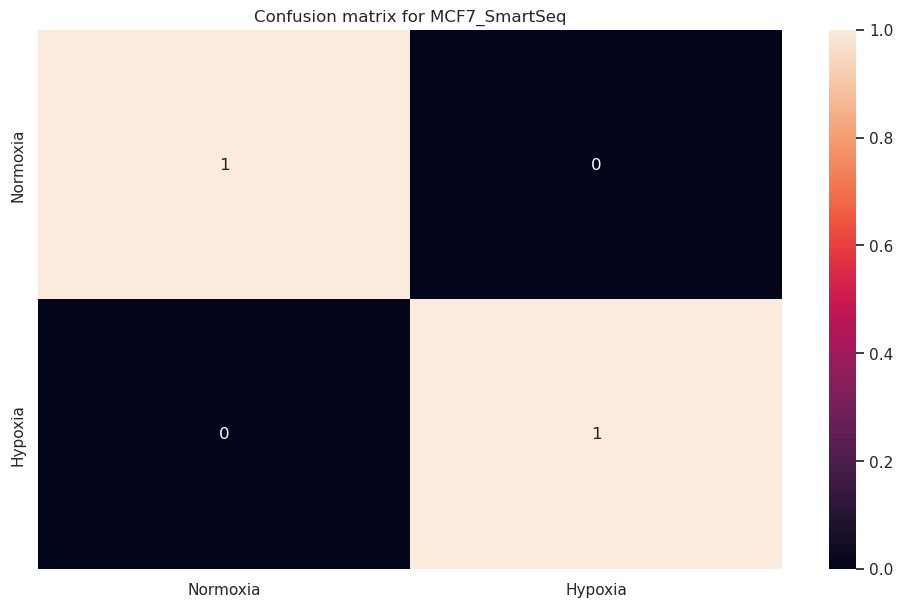

Evaluating the performance on the test set for HCC1806_SmartSeq:

ROC AUC: 1.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


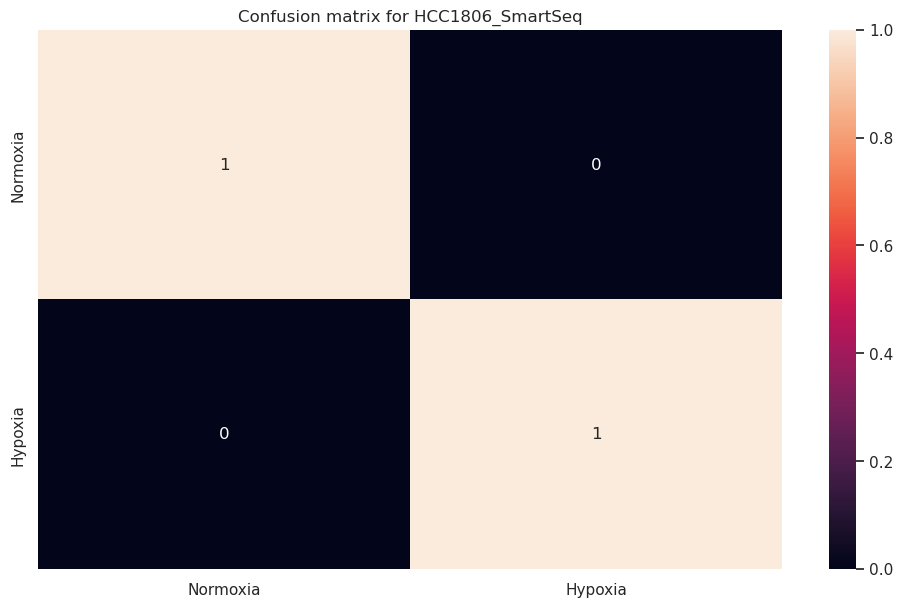

Evaluating the performance on the test set for MCF7_DropSeq:

ROC AUC: 0.9926404559925474
Accuracy: 0.9819694868238558
F1: 0.9847834568864612
Precision: 0.9813374805598756
Recall: 0.9882537196554424


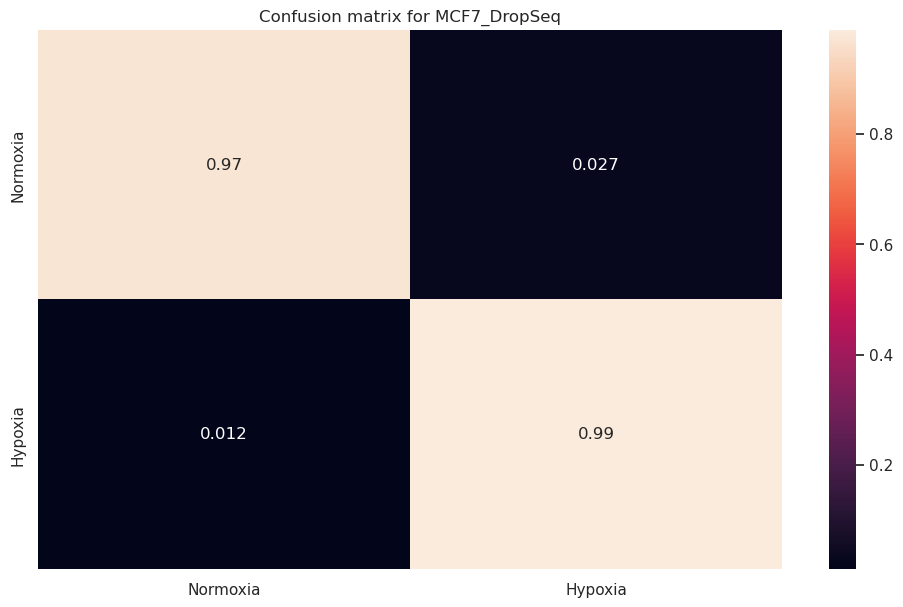

Evaluating the performance on the test set for HCC1806_DropSeq:

ROC AUC: 0.991898357957349
Accuracy: 0.961525366019748
F1: 0.9510610653962754
Precision: 0.9581151832460733
Recall: 0.944110060189166


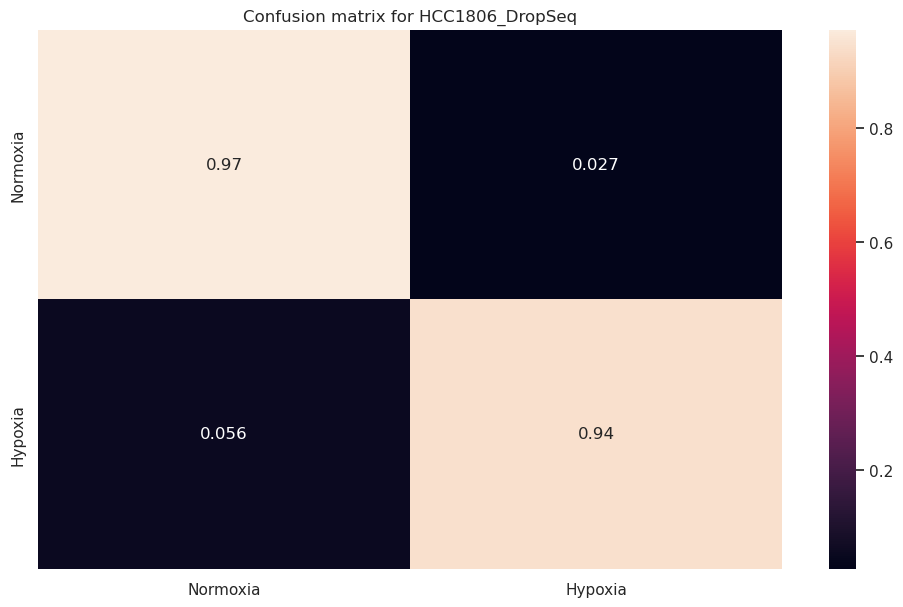

In [85]:
for name, df in datasets.items():
    voting_clf = VotingClassifier(estimators=[('xgboost_mkII', models[name]['xgboost_mkII']), ('rf', models[name]['rf']), ('kan', models[name]['kan'])], voting="soft")
    voting_clf.fit(datasets_train[name].values, datasets_train[name].index.isin(merged_norm_idx))
    model_test_performance(name, voting_clf, datasets_test[name].values, datasets_test[name].index.isin(merged_norm_idx), probability=True)

# TODO: Remove These

In [ ]:
torch.save(model.state_dict(), "KAN_SMART_HCC_Smalljdnf.checkpoint")